In [1]:
from __future__ import print_function
import time
import numpy as np
import tables as tb
import matplotlib.pyplot as plt

import tblFunctions as tbl
from HLObjects import Signal, Peak, PMap

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Run last on {} at {}".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

Run last on 11/11/2016 at 12:09:33


In [79]:
try:
    f.close()
except:
    pass

In [80]:
f = tb.open_file("/Users/Gonzalo/github/IC/data/MC/Kr_preprod_pmaps.h5")

In [81]:
print(f)

/Users/Gonzalo/github/IC/data/MC/Kr_preprod_pmaps.h5 (File) ''
Last modif.: 'Fri Nov 11 13:04:02 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(686,), zlib(4)) ''
/PMAPS (Group) ''
/PMAPS/PMaps (Table(13579,), shuffle, zlib(4)) 'Store for PMaps'
/PMAPS/PMapsBLR (Table(13535,), shuffle, zlib(4)) 'Store for PMaps made with BLR'
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''



In [82]:
pmaps_ = f.root.PMAPS.PMaps
blrs_ = f.root.PMAPS.PMapsBLR

# PMaps study

In [83]:
nevt = len(set(pmaps_.cols.event))
pmaps = np.empty(nevt, dtype=object)
npeaks = np.empty(nevt)
t0s = np.empty(nevt)
nS1 = np.empty(nevt)
nS2 = np.empty(nevt)
nUN = np.empty(nevt)
for i in range(nevt):
    pmaps[i] = pmap = tbl.read_pmap(pmaps_, i)
    npeaks[i] = len(pmap.peaks)
    t0s[i] = pmap.t0
    sigs = [p.signal for p in pmap.peaks]
    nS1[i] = sigs.count(Signal.S1)
    nS2[i] = sigs.count(Signal.S2)
    nUN[i] = sigs.count(Signal.UNKNOWN)

## Histogram of the number of peaks

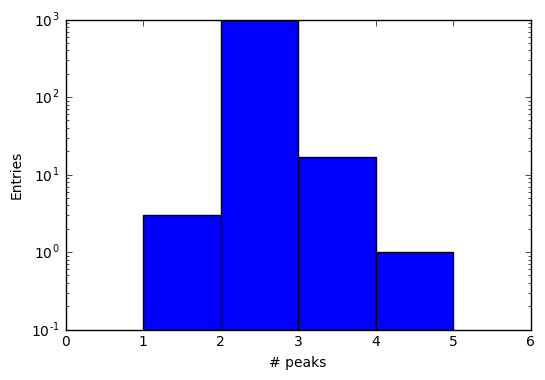

In [84]:
h = plt.hist(npeaks,6,range=(0,6))
plt.xlabel("# peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

## Histogram of the number of S1 peaks per event

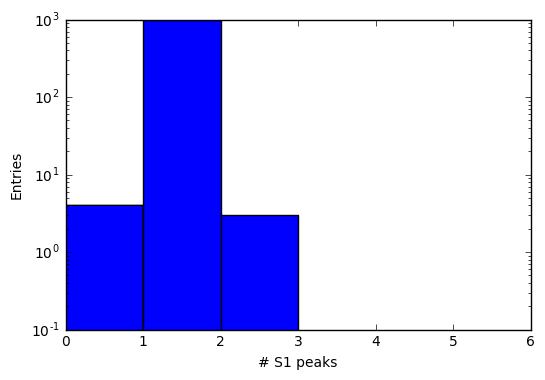

In [85]:
h = plt.hist(nS1,6,range=(0,6))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

## Histogram of the number of S2 peaks per event

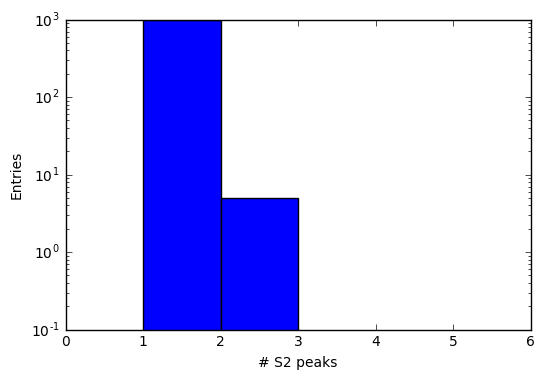

In [86]:
h = plt.hist(nS2,6,range=(0,6))
plt.xlabel("# S2 peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

## Histogram of the number of unclassified peaks per event

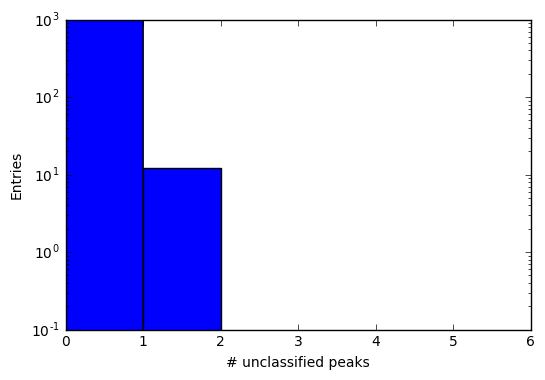

In [87]:
h = plt.hist(nUN,6,range=(0,6))
plt.xlabel("# unclassified peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

**Stats**
1. 0.4% of the events have no S1
2. 0.3% of the events have more than one S1
3. 0.5% of the events have more than one S2
4. 1.0% of the events have unclassified (extra) peaks


## Histogram of the t0 (not yet set)

(0.1, 1000)

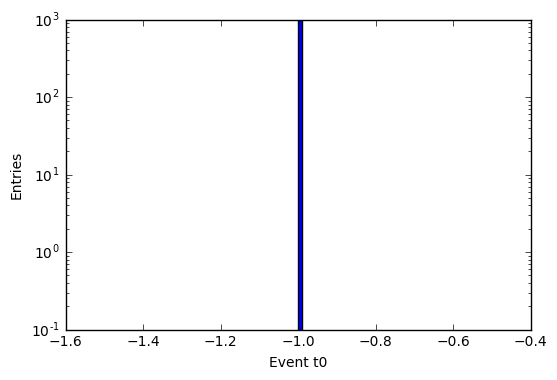

In [88]:
plt.hist(t0s, 100)
plt.xlabel("Event t0")
plt.ylabel("Entries")
plt.yscale("log")
plt.ylim((1e-1,nevt))

## A plot of one PMap with several peaks

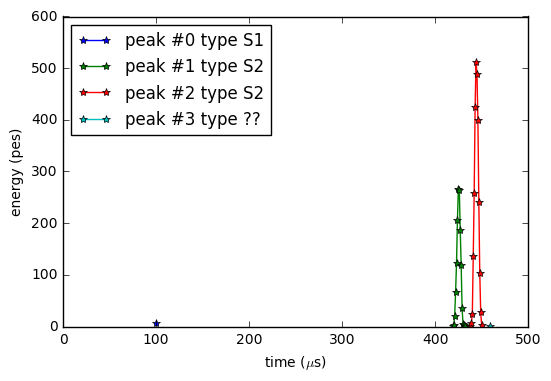

In [89]:
def plot_pmap(pmap):
    for i, peak in enumerate(pmap.peaks):
        t = peak.times
        tot = peak.tothrs
        cat = peak.cathode
        ano = peak.anode.sum(axis=1)
        plt.plot(t, cat, '*-', label="peak #{} type {}".format(i, peak.signal))

    plt.legend(loc="upper left")
    plt.xlabel("time ($\mu$s)")
    plt.ylabel("energy (pes)")
    plt.xlim((0, plt.xlim()[1]))
    plt.ylim((0, plt.ylim()[1]))

plot_pmap(pmaps[205])

## Histogram of the number of non-zero 25ns-samples in the same peak

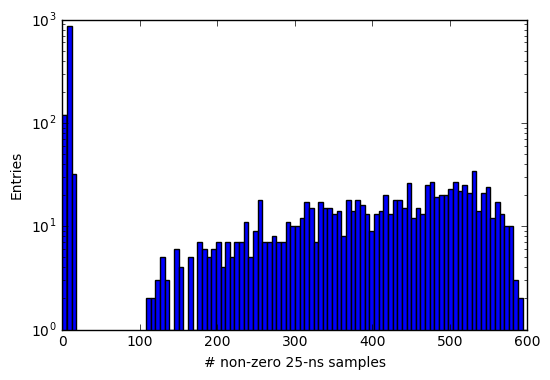

In [90]:
data = [pk.tothrs.sum() for pmap in pmaps for pk in pmap.peaks]
h = plt.hist(np.array(data).flatten(), 100, range=(0,600))
plt.xlabel("# non-zero 25-ns samples")
plt.ylabel("Entries")
plt.yscale("log")

## Histogram of the width of the peaks

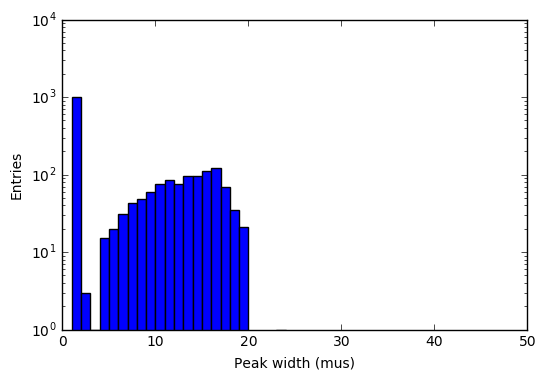

In [91]:
data = [pk.width for pmap in pmaps for pk in pmap.peaks]
h = plt.hist(np.array(data).flatten(), 50, range=(0,50))
plt.xlabel("Peak width (mus)")
plt.ylabel("Entries")
plt.yscale('log')

## Scatter plot of the number of non-zero samples vs width of the peaks

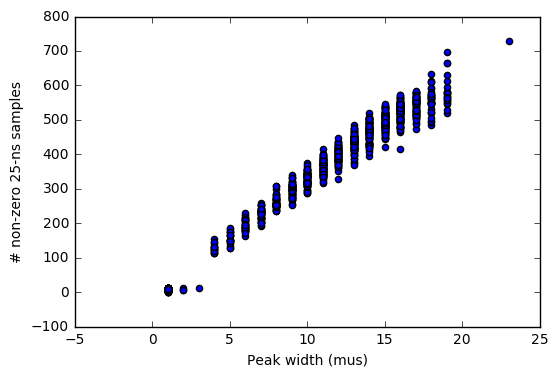

In [92]:
width, tot = zip(*[(pk.width, pk.tothrs.sum()) for pmap in pmaps for pk in pmap.peaks])
h = plt.scatter(width, tot)
plt.xlabel("Peak width (mus)")
plt.ylabel("# non-zero 25-ns samples")

## Histogram of the width of the peaks for non-zero samples < 20

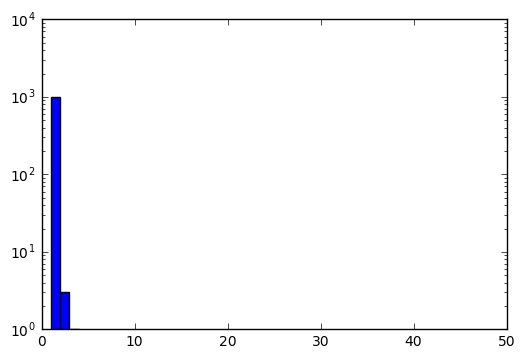

In [93]:
data = [pk.width for pmap in pmaps for pk in pmap.peaks if pk.tothrs.sum()<20]
h = plt.hist(np.array(data).flatten(), 50, range=(0,50))
plt.yscale('log')

## Histogram of the number of non-zero samples for 1-mus peaks

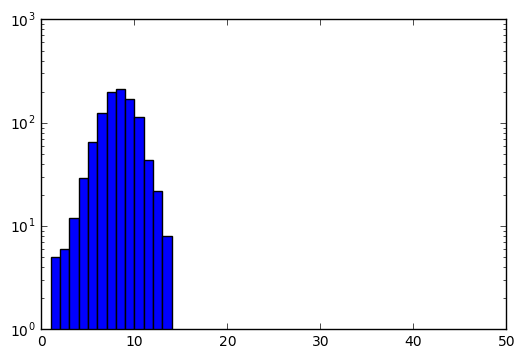

In [94]:
data = [pk.tothrs.sum() for pmap in pmaps for pk in pmap.peaks if pk.width==1.]
h = plt.hist(np.array(data).flatten(), 50, range=(0,50))
plt.yscale('log')

## Histogram of S2 peaks integral

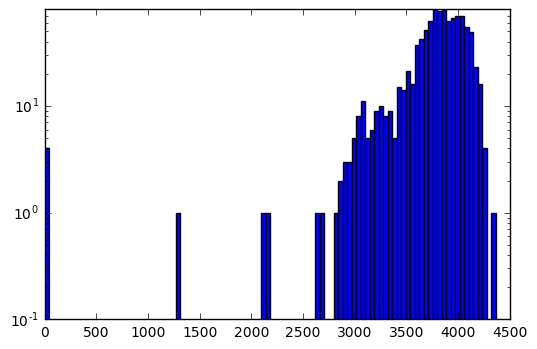

In [97]:
data = [pk.cathode_integral for pmap in pmaps for pk in pmap.peaks if pk.signal == Signal.S2]
h = plt.hist(np.array(data).flatten(), 100)
plt.ylim(1e-1, plt.ylim()[1])
plt.yscale('log')

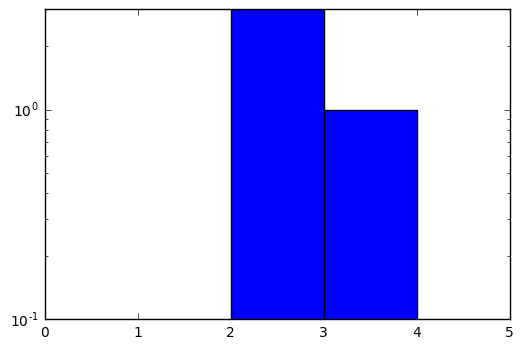

In [101]:
data = [pk.width for pmap in pmaps for pk in pmap.peaks if pk.signal == Signal.S2 and pk.cathode_integral < 100]
h = plt.hist(np.array(data).flatten(), 5, range=(0,5))
plt.ylim(1e-1, plt.ylim()[1])
plt.yscale('log')

**The "empty" S2 peaks are probably fluctuations of the noise or fluctuations of a real S2 peak around the threshold.
This kind of events is a 0.4% of the total.**